# Base Models
In this notebook, we'll build some base models with PyMC. 
We start with an intercept-only model (basically estimating the mean) and then extend this to a linear model.
For both models we try some different likelihoods, namely a normal likelihood as well as a Student-T likelihood (robust model).

In [1]:
import sys
import os
from pathlib import Path 

import pandas as pd
import numpy as np
import arviz as az
import pymc3 as pm
import xarray as xr
import bambi as bmb
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))

from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults, plot_price_area
from projects.common.berlin_housing.utils.data_utils import load_data
from projects.common.berlin_housing.utils.data_utils import destandardize_area, destandardize_price, load_data, standardize_area
from projects.common.berlin_housing.utils.plot_utils import set_plot_defaults

DATA_DIR = PROJECT_DIR / 'data'  / 'berlin_housing' / 'interim_data'
DATA_DIR

PosixPath('/media/david/T7/code/bmcp/bmcp-notes/data/berlin_housing/interim_data')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
xr.set_options(display_expand_data=False, display_expand_attrs=False, display_expand_coords=False,
              display_expand_data_vars=False)
SEED = 1925

%load_ext watermark
%watermark --iversions

seaborn   : 0.11.2
bambi     : 0.6.3
pandas    : 1.3.2
sys       : 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:23:11) 
[GCC 9.4.0]
arviz     : 0.11.2
xarray    : 0.19.0
pymc3     : 3.11.4
matplotlib: 3.4.3
numpy     : 1.19.5



### Data Prep
+ pymc chokes on raw rent, but is OK on rent / 100 `rent` -> `rent_s`
+ living space is in (I think) square metres. This is standardized - (subtract mean / by stdev) `living_space` -> `living_space_s`

In [3]:
df_orig, _, _ = load_data(kind="rents")
df_orig['rent_std'] = StandardScaler().fit_transform(df_orig[['rent']])
df_orig = df_orig[df_orig['rent'] < 7500]
# pymc chokes on raw rent, but is OK on rent / 100 
df_orig['rent_s'] = df_orig['rent'] / 100
df_orig['living_space_std'] = StandardScaler().fit_transform(df_orig[['living_space']])
target = 'rent_s'
df_orig.head()

,zip,rent,rent_s,log_rent,log_rent_s,sqm_rent,log_sqm_rent,log_sqm_rent_s,living_space,living_space_s,offer_year,const_year,const_year_s,flattype,interior_qual,zip_code,rent_std,living_space_std
59,12103,941.0,9.410,6.846943,-0.037463,30.354839,3.412956,2.350673,31.00,-1.145711,2019,2019.0,1.152406,NaN,NaN,84,-0.233760,-1.194297
75,14109,1399.7,13.997,7.244013,0.651780,16.999028,2.833156,0.728184,82.34,-0.002587,2019,1920.0,-0.933787,apartment,sophisticated,199,0.263925,0.011171
84,13086,830.0,8.300,6.721426,-0.255338,8.251317,2.110373,-1.294424,100.59,0.403763,2019,1912.0,-1.102368,ground_floor,normal,148,-0.354194,0.439683
86,10785,3417.6,34.176,8.136694,2.201314,16.000000,2.772589,0.558695,213.60,2.920016,2019,2018.0,1.131333,penthouse,sophisticated,55,2.453326,3.093170
136,12057,490.0,4.900,6.194405,-1.170151,10.000000,2.302585,-0.756545,49.00,-0.744927,2019,1972.0,0.161991,apartment,normal,79,-0.723090,-0.771655


In [4]:
df = df_orig.copy()
df[['rent', 'rent_s']].describe()

,rent,rent_s
count,7244.000000,7244.000000
mean,1134.802105,11.348021
std,763.917138,7.639171
min,178.160000,1.781600
25%,630.000000,6.300000
50%,913.830000,9.138300
75%,1409.700000,14.097000
max,7000.000000,70.000000


## Mean of Rent Proces (Intercept only model)
+ From describe data above, mean about 11.3 and stdev about 7.6 

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{HalfNormal}(10)
\end{align*}$$

I'm also trying out different priors for $\sigma$. If you want to know more about which priors are recommended for which kind of model, check this [prior recommendation](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations) by the Stan team.

In [5]:
with pm.Model() as intercept_normal:
    mu = pm.Normal("mu", mu=0, sd=10)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    y = pm.Normal("y", mu=mu, sd=sigma, observed = df[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

/tmp/ipykernel_10486/4134594484.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


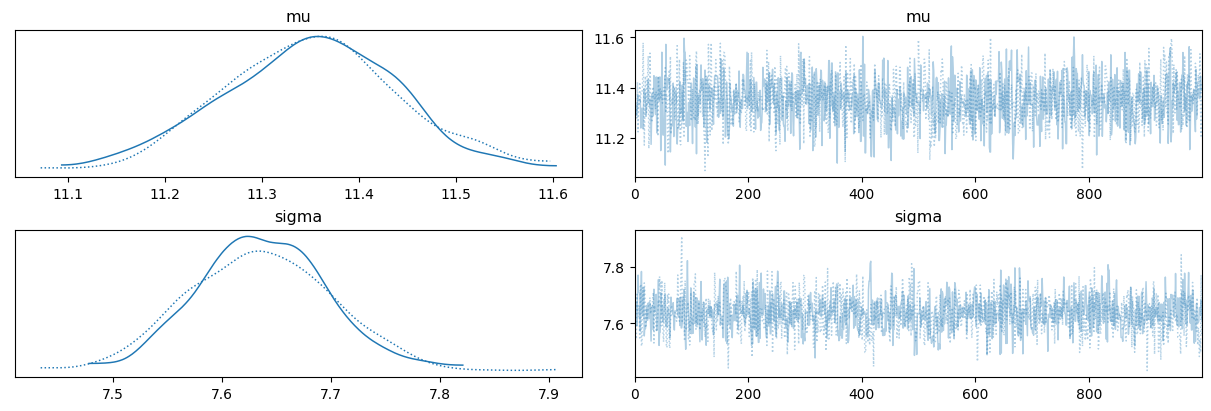

In [6]:
az.plot_trace(trace, coords={"chain":[0,1]})
plt.show()

In [7]:
az.loo(az.from_pymc3(trace=trace))

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Computed from 4000 by 7244 log-likelihood matrix

         Estimate       SE
elpd_loo -25011.58   140.57
p_loo        6.34        -

More sensible priors (below) give a similar result and similar loo, so looks like the data washes out the priors 

In [8]:
with pm.Model() as intercept_normal:
    mu = pm.Normal("mu", mu=10, sd=3.33)
    sigma = pm.HalfNormal("sigma", sd=10)
    
    y = pm.Normal("y", mu=mu, sd=sigma, observed = df[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

/tmp/ipykernel_10486/93150556.py:7: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


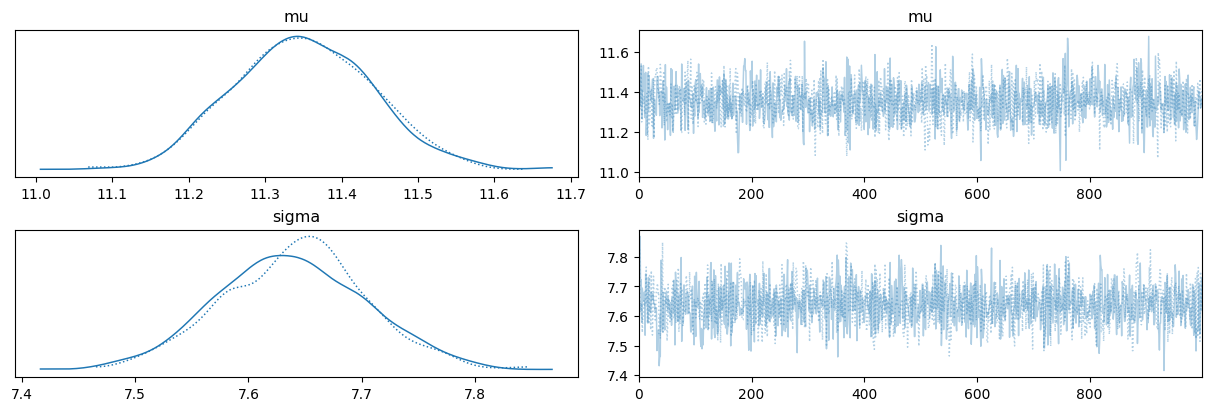

In [9]:
az.plot_trace(trace, coords={"chain":[0,1]})
plt.show()

In [10]:
az.loo(az.from_pymc3(trace=trace))

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Computed from 4000 by 7244 log-likelihood matrix

         Estimate       SE
elpd_loo -25011.82   140.53
p_loo        6.69        -

The robust version of this model uses  Student-T likelihood instead:
$$\begin{align*}
price &\sim \text{Student-T}(\mu, \sigma, \nu)\\
\mu &\sim \text{Normal}(0, 10)\\
\sigma &\sim \text{HalfCauchy}(10)\\
\nu &\sim \text{Gamma}(\alpha=2, \beta=0.1)
\end{align*}$$

In [11]:
with pm.Model() as intercept_student:
    mu = pm.Normal("mu", mu=0, sd=20)
    sigma = pm.HalfCauchy("sigma", 10)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    
    y = pm.StudentT("y", mu=mu, sd=sigma, nu=nu, observed=df[target])
    
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

/tmp/ipykernel_10486/2788972324.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


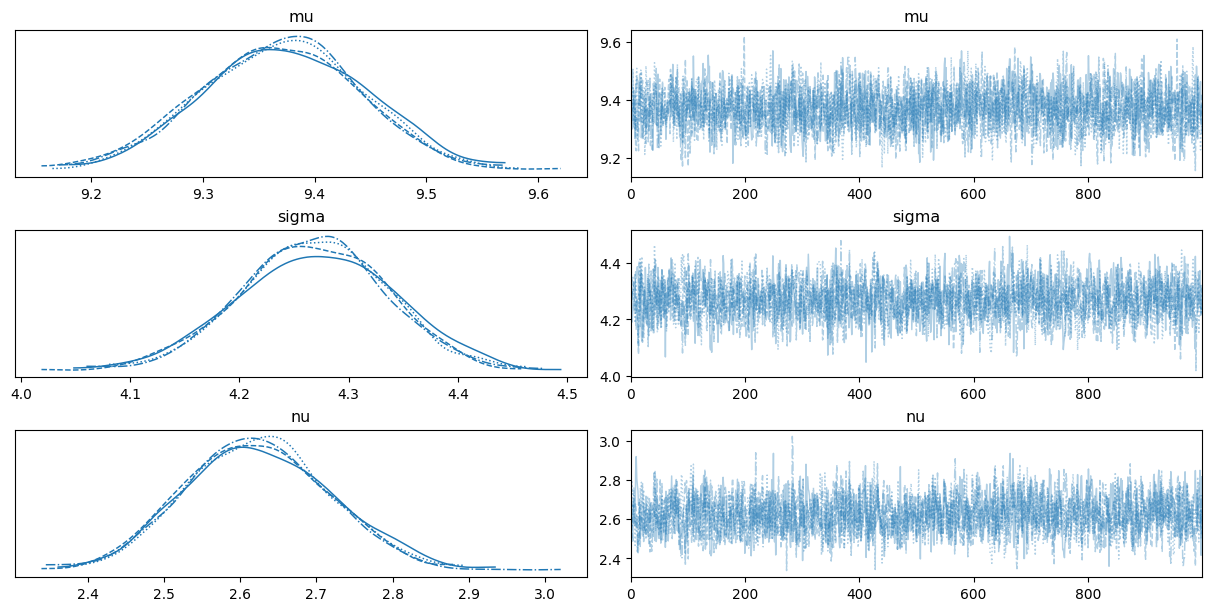

In [12]:
az.plot_trace(trace)
plt.show()

In [13]:
az.loo(az.from_pymc3(trace=trace))

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Computed from 4000 by 7244 log-likelihood matrix

         Estimate       SE
elpd_loo -23750.63    97.93
p_loo        3.34        -

Student t model scores best

## Linear base model
We add the predictor of the living area to the model. Note that the living area is standardized, so that the intercept represents the price for an average-sized home (which is 101sqm).

$$\begin{align*}
price &\sim \text{Normal}(\mu, \sigma)\\
\mu &= \alpha + \beta \;\text{living_space}\\
\alpha &\sim \text{Normal}(0, 10) \\
\beta &\sim \text{Normal}(0, 1) \\
\sigma &\sim \text{Exponential}(1/5)
\end{align*}$$

In [14]:
with pm.Model() as lin_normal:
    living_space = pm.Data("living_space_std", df["living_space_std"])
    
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*living_space
    
    sigma = pm.Exponential("sigma", 1/5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=df["rent_s"])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)

/tmp/ipykernel_10486/499470682.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


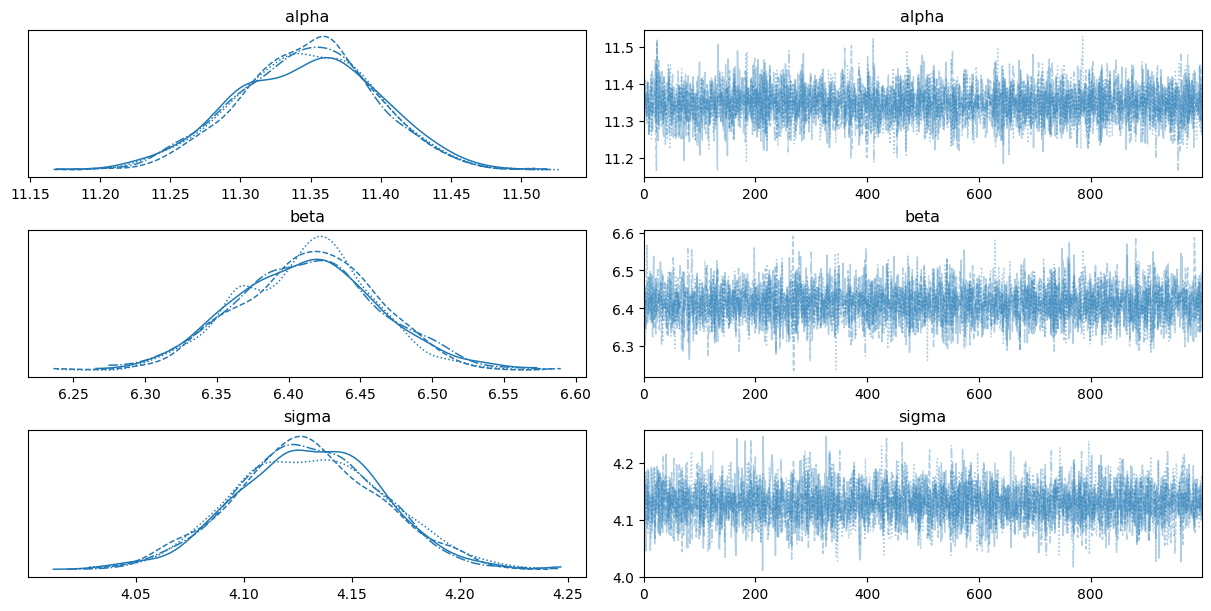

In [15]:
az.plot_trace(trace)
plt.show()

In [16]:
az.loo(az.from_pymc3(trace=trace))

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.


Computed from 4000 by 7244 log-likelihood matrix

         Estimate       SE
elpd_loo -20559.44   160.52
p_loo       14.19        -

There has been a warning during the calculation. Please check the results.

We can do the same with a Student likelihood:

In [17]:
with pm.Model() as lin_student:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=1)
    mu = alpha + beta*df["living_space_s"]
    
    sigma = pm.HalfCauchy("sigma", 5)
    nu = pm.Gamma("nu", alpha=2, beta=0.1)
    y = pm.StudentT("y", nu=nu, mu=mu, sd=sigma, observed=df[target])
    trace = pm.sample(random_seed=2412, chains=4, 
                      draws=1000, tune=1000)
    
    prior = pm.sample_prior_predictive()

/tmp/ipykernel_10486/2837279317.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu, sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


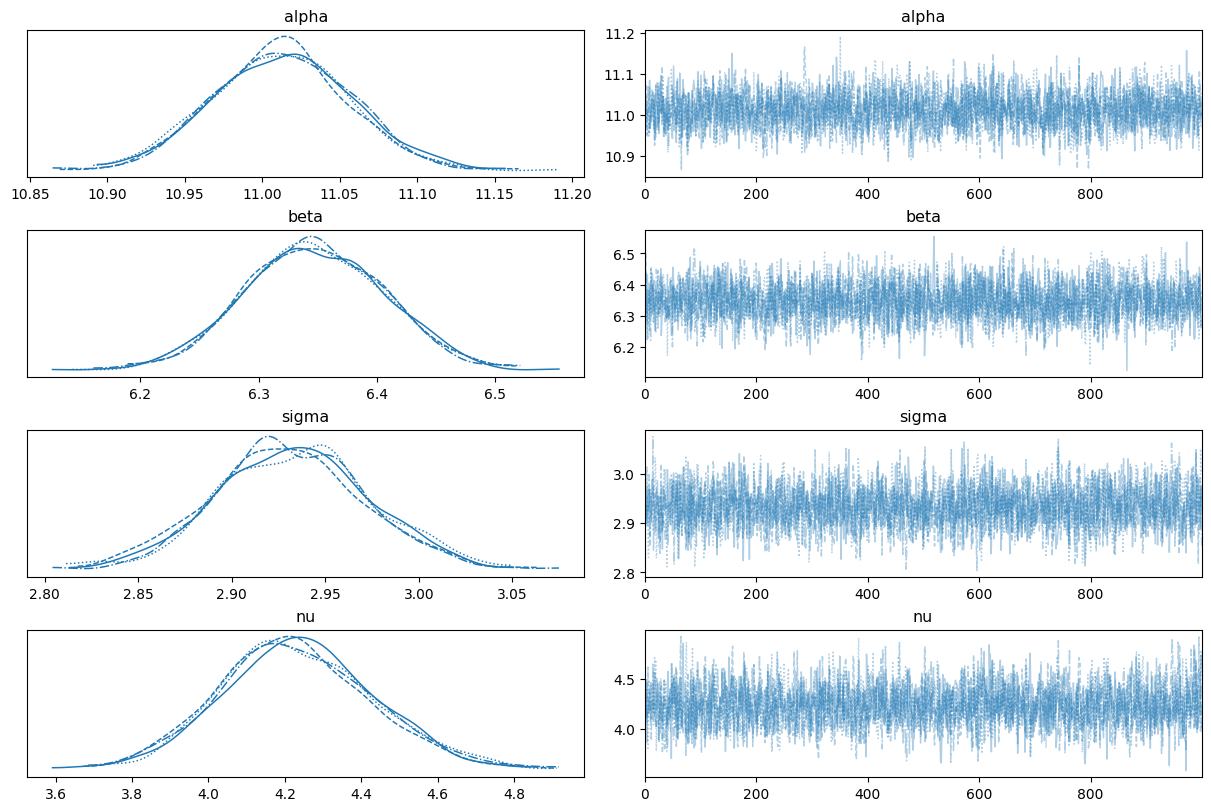

In [18]:
az.plot_trace(trace)
plt.show()

In [19]:
az.loo(az.from_pymc3(trace=trace))

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.


Computed from 4000 by 7244 log-likelihood matrix

         Estimate       SE
elpd_loo -19874.93    84.84
p_loo        5.63        -